Systematic Uncertainty Modelling
===

In the `Neural_Likelihood_Ratio_Estimation.ipynb` notebook, we left out the nuisance parameter piece of the parameterized density ratio decomposition:

$$g_c(x|\alpha) = \frac{p_c(x|\alpha)}{p_c(x)} = \prod_m \frac{p_c(x|\alpha_m^{eval})}{p_c(x)}$$

where the second equality assumes that the effect of various sources of uncertainty in the model can be factorized. This is another density ratio estimation problem, but instead of training m $\alpha-$parameterized NNs, we use a HistFactory-style interpolation generalized to a per-event formulation:

$$\frac{p_c(x|\alpha_m^{eval})}{p_c(x)} = \begin{cases}
    \left(\frac{p_c(x|\alpha_m^+)}{p_c(x)}\right)^{\alpha_m^\text{eval}}& \alpha_m^\text{eval}>1\\
    1+\sum_{n=1}^6c_n\cdot (\alpha_m^\text{eval})^n& -1\leq\alpha_m^\text{eval}\leq 1\\
    \left(\frac{p_c(x|\alpha_m^-)}{p_c(x)}\right)^{-\alpha_m^\text{eval}}& \alpha_m^\text{eval}<-1\\
    \end{cases}$$

where $\alpha=\{\alpha_m^{eval}\}$ and for each nuisance parameter $m$, we have three simulation models - $p_c(x), p_c(x|\alpha_m^+), p_c(x|\alpha_m^-)$. Naturally, this still requires NNs to estimate the density ratios:

$$\frac{p_c(x|\alpha_m^+)}{p_c(x)} \, , \frac{p_c(x|\alpha_m^-)}{p_c(x)}$$

**These are the density ratios that we will estimate using NNs in this notebook.**
Two ratios corresponding to each $\alpha_m^\pm$ will be trained for each systematic uncertainty indexed by $m$ and for each channel $c$ to build the final parameterized model, 

$$\frac{p(x|\mu, \alpha)}{p_{ref}(x)} = \frac{1}{\sum_c G_c(\alpha) \cdot f_c(\mu) \cdot \nu_c} \sum_c f_c(\mu) \cdot G_c(\alpha) \cdot \nu_c \cdot g_c(x|\alpha) \cdot \frac{p_c\left(x\right)}{p_{ref}(x)}$$

The full workflow for building $\mu, \alpha-$parameterized density ratios is represented in the flowchart below:

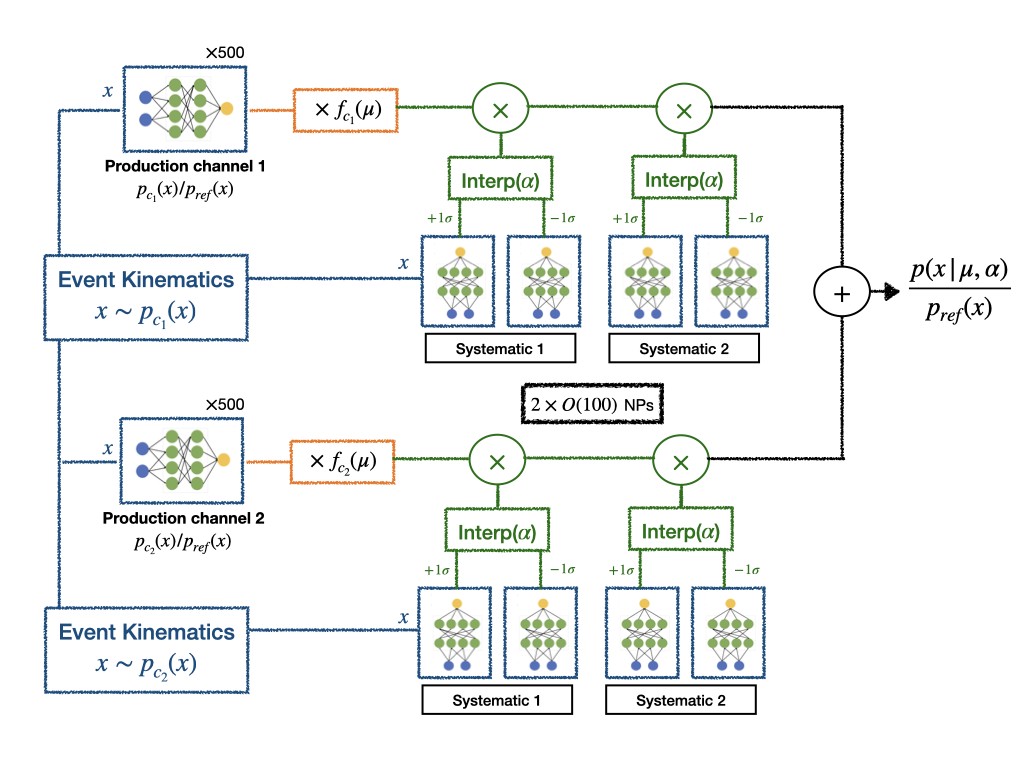

In [26]:
import os, sys, importlib
# sys.path.append('/home/jaySandesara/NSBI_workflow_tutorial/FAIR_universe_Higgs_tautau/')

import nsbi_common_utils
from nsbi_common_utils import plotting, training
from nsbi_common_utils.training import TrainEvaluate_NN, TrainEvaluatePreselNN

from utils import calculate_preselection_observable, preselection_using_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from tensorflow.keras.optimizers import Nadam
import mplhep as hep
import matplotlib.pyplot as plt
import pickle

import numpy as np

from coffea.analysis_tools import PackedSelection

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

hep.style.use(hep.style.ATLAS)

In [27]:
# Save/load the datasets from pre-processed input
path_prefix = '/home/jaySandesara/NSBI_workflow_tutorial/FAIR_universe_Higgs_tautau/'
saved_data = f'{path_prefix}cached_data/'

# Systematics and which samples are affected by which systematics
dict_systs = {'TES': {'process':['htautau', 'ttbar', 'ztautau'], 'directions':['up','dn']},
              'JES': {'process':['htautau', 'ttbar', 'ztautau'], 'directions':['up','dn']}}

# Systematics and which samples are affected by which systematics
dict_systs = {'TES': {'process':['htautau', 'ttbar', 'ztautau'], 'directions':['up','dn']}}

datasets_syst = {}

for syst in dict_systs:

    datasets_syst[syst] = {}

    for direction in dict_systs[syst]['directions']:

        datasets_syst[syst][direction] = pd.read_hdf(f"{saved_data}df_{syst}_{direction}.h5", key="dataset")


dataset_nom = pd.read_hdf(f"{saved_data}df_nominal.h5", key="dataset")

presel_score_nom = np.load(f"{saved_data}presel_score.npy")
dataset_nom['presel_score'] = presel_score_nom

list_syst = [key for key in dict_systs]
print(list_syst)

['TES']


In [28]:
# Get the dictionary of labels to processes
labels_dict = np.load(f"{saved_data}labels_dictionary.npy", allow_pickle=True).item()

signal_processes = np.load(f"{saved_data}signal_processes.npy")
background_processes = np.load(f"{saved_data}background_processes.npy")
pre_factor = np.load(f"{saved_data}pre_factor_preselection.npy", allow_pickle=True).item()

columns = np.load(f"{saved_data}columns.npy")
columns_scaling = np.load(f"{saved_data}columns_scaling.npy")

In [29]:
importlib.reload(sys.modules['nsbi_common_utils.training'])
from nsbi_common_utils.training import TrainEvaluatePreselNN

path_to_saved_presel_model = f'{path_prefix}preselection_saved_NN/'

num_classes = len(labels_dict)

for syst in datasets_syst:

    for direction in datasets_syst[syst]:

        # Skip preselection score calculation if already done in a previous round
        if 'presel_score' in list(datasets_syst[syst][direction].columns): continue

        dataset = datasets_syst[syst][direction]
    
        preselectionTraining = TrainEvaluatePreselNN(dataset, num_classes, columns, columns_scaling)
        preselectionTraining.get_trained_model(path_to_saved_presel_model)
        pred_NN_incl = preselectionTraining.predict(dataset)

        presel_score = calculate_preselection_observable(pred_NN_incl, labels_dict, signal_processes, background_processes)

        datasets_syst[syst][direction]['presel_score'] = presel_score

        # Overwrite saved dataframe with preselection score saved for future iterations
        datasets_syst[syst][direction].to_hdf(f"{saved_data}df_{syst}_{direction}.h5", key="dataset", mode="w")

        del dataset, presel_score, pred_NN_incl

I0000 00:00:1749071405.307835     903 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1215 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB MIG 1g.5gb, pci bus id: 0000:c1:00.0, compute capability: 8.0


     1/223008 ━━━━━━━━━━━━━━━━━━━━ 15:37:04 252ms/step

I0000 00:00:1749071406.381293  242365 service.cc:148] XLA service 0x7ef8c4003bc0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1749071406.381329  242365 service.cc:156]   StreamExecutor device (0): NVIDIA A100-SXM4-40GB MIG 1g.5gb, Compute Capability 8.0
2025-06-04 21:10:06.387058: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1749071406.405161  242365 cuda_dnn.cc:529] Loaded cuDNN version 90501
I0000 00:00:1749071406.485987  242365 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


223008/223008 ━━━━━━━━━━━━━━━━━━━━ 258s 1ms/step
214371/214371 ━━━━━━━━━━━━━━━━━━━━ 180s 840us/step


In [30]:
preselection_cuts = np.load(f"{saved_data}preselection_cuts.npy", allow_pickle=True).item()

dataset_nom_SR, dataset_nom_CR = preselection_using_score(dataset_nom, preselection_cuts)

datasets_syst_SR = {}
datasets_syst_CR = {}

for syst in datasets_syst:

    datasets_syst_SR[syst] = {}
    datasets_syst_CR[syst] = {}
    
    for direction in datasets_syst[syst]:

        datasets_syst_SR[syst][direction], datasets_syst_CR[syst][direction] = preselection_using_score(datasets_syst[syst][direction], preselection_cuts)


del dataset_nom, datasets_syst

Signal and Control Regions
===

The SR needs additional density ratios to be trained, whereas the CR follows the standard procedure of template histogram building.

In [31]:
# Load the Control Region observable
with open(f"{saved_data}hist_CR_ttbar.pkl", "rb") as fp:
    hist_CR = pickle.load(fp)

bins_CR = np.load(f"{saved_data}CRbins.npy")
observable_CR = np.load(f"{saved_data}observable_CR.npy")

min_presel_bin = bins_CR[0]
max_presel_bin = bins_CR[-1]

In [32]:
hist_var = {}

for process in labels_dict:
    
    hist_var[process] = {}
    
    for syst in dict_systs:

        hist_var[process][syst] = {}

        for direction in ['up', 'dn']:

            hist_var[process][syst][direction] = {}
            
            mask_process = (datasets_syst_CR[syst][direction].type==process)
        
            if (process not in dict_systs[syst]['process']) | (direction not in dict_systs[syst]['directions']):
                hist_var[process][syst][direction] = np.ones_like(hist_CR[process])

            else:

                dataset_process = datasets_syst_CR[syst][direction][mask_process].copy()
                
                hist_var[process][syst][direction] = np.histogram(np.clip(dataset_process[observable_CR].ravel(), 
                                                                    min_presel_bin, max_presel_bin), 
                                                                    weights = dataset_process['weights'].ravel(),
                                                                    bins = bins_CR)[0]/hist_CR[process]

                del dataset_process


print(hist_var)

{'htautau': {'TES': {'up': array([0.9743341, 0.9780137, 0.9857338, 0.9961984, 1.0157472, 1.0388693,
       1.0544205, 1.0616016, 1.0856767], dtype=float32), 'dn': array([1.029834  , 1.0212245 , 1.0143754 , 1.008144  , 0.9838877 ,
       0.9640952 , 0.9515798 , 0.93736804, 0.92158556], dtype=float32)}}, 'ztautau': {'TES': {'up': array([0.9791733 , 0.99853134, 1.0344516 , 1.0843577 , 1.0996741 ,
       1.0625144 , 1.057553  , 1.0519727 , 1.0774701 ], dtype=float32), 'dn': array([1.0200604 , 0.99594206, 0.956618  , 0.9037914 , 0.90047884,
       0.9408575 , 0.9514514 , 0.95515764, 0.9254666 ], dtype=float32)}}, 'ttbar': {'TES': {'up': array([0.99744385, 0.997931  , 1.0087905 , 1.0177298 , 1.0122812 ,
       1.0111024 , 1.0276462 , 1.0240527 , 1.0543579 ], dtype=float32), 'dn': array([1.0012113 , 0.99919033, 0.99213964, 0.9880833 , 0.9844096 ,
       0.99073875, 0.970912  , 0.97410023, 0.94847494], dtype=float32)}}}


In [33]:
# Save the Control Region variation histogram
with open(f"{saved_data}hist_CR_variations.pkl", "wb") as fp:
    pickle.dump(hist_var, fp)

Density ratio training
===

Now we train the NNs for $\frac{p_c}{p_{ref}}(x)$ density ratios to build the full model. Our choice of reference hypothesis, motivated by the search-oriented mixture model described above, is: 

$$p_{ref}(x) = p_\text{ttbar}(x) = \frac{1}{\nu_\text{ttbar}} \frac{d\sigma_\text{ttbar}}{dx} $$

gives the POI $\mu-$parameterized model:

$$\sum_c \left[f_c(\mu) \cdot \frac{p_c\left(x\right)}{p_{ref}(x)} \right]= \mu + \frac{p_\text{wjets}\left(x\right)}{p_\text{ttbar}(x)} + \frac{p_\text{single top}\left(x\right)}{p_\text{ttbar}(x)}$$

The task of estimating the $\mu-$parameterized density ratio is thus reduced to estimating two $\mu-$independent density ratios $\frac{p_\text{single top}}{p_{t\bar{t}}}(x)$ and $\frac{p_\text{wjets}}{p_{t\bar{t}}}(x)$ mixed together with an analytical parameterization (hence the name mixture model).

In [37]:
importlib.reload(sys.modules['nsbi_common_utils.training'])
from nsbi_common_utils.training import TrainEvaluate_NN

ref_processes = np.load(f"{saved_data}ref_processes.npy")

dataset_syst_process = {}
NN_training_syst_process = {}

rnd_seed_traintestsplit = 42 # can also be randomized, fixed for now

for process in labels_dict:
    
    NN_training_syst_process[process] = {}

    mask_process_nom = (dataset_nom_SR.type==process)
    dataset_den = dataset_nom_SR[mask_process_nom].copy()
    
    for syst in dict_systs:

        if process not in dict_systs[syst]['process']:
            print(f"Nothing to train for {process} in {syst} uncertainty")
            continue
        
        NN_training_syst_process[process][syst] = {}
        
        for direction in dict_systs[syst]['directions']:

            mask_process_syst = (datasets_syst_SR[syst][direction].type==process)
            
            # Save paths
            top_path = f'{path_prefix}output_training_systematics/'

            output_name = f'{process}_{syst}_{direction}'
            output_dir = f'{top_path}general_output_{process}_{syst}_{direction}'
            path_to_ratios = f'{top_path}output_ratios_{process}_{syst}_{direction}/'
            path_to_figures = f'{top_path}output_figures_{process}_{syst}_{direction}/'
            path_to_models = f'{top_path}output_model_params_{process}_{syst}_{direction}/'

            dataset_num = datasets_syst_SR[syst][direction][mask_process_syst].copy()

            # print(f"Variation ratio for {syst} is {dataset_num['weights'].sum()/dataset_den['weights'].sum()}")

            dataset_num['train_labels'] = 1
            dataset_den['train_labels'] = 0

            dataset_num['weights_normed'] = dataset_num['weights'].to_numpy() / dataset_num['weights'].sum()
            dataset_den['weights_normed'] = dataset_den['weights'].to_numpy() / dataset_den['weights'].sum()
            
            # Build a training dataset for the training of p_<process_type>/p_<ref_processes> density ratio
            dataset_syst_process = pd.concat([dataset_num, dataset_den])

            
            NN_training_syst_process[process][syst][direction] = TrainEvaluate_NN(dataset_syst_process, 
                                                                                   dataset_syst_process['weights_normed'],
                                                                                   dataset_syst_process['train_labels'],
                                                                                   columns, 
                                                                                   columns_scaling, rnd_seed_traintestsplit,
                                                                                   [syst+'_'+direction, process], output_dir, output_name, 
                                                                                    path_to_figures=path_to_figures,
                                                                                    path_to_ratios=path_to_ratios, 
                                                                                    path_to_models=path_to_models)

    del dataset_num, dataset_den
                




 Training for TES


Sum of weights of class 0: 0.6999996900558472
Sum of weights of class 1: 0.7000009417533875
Using swish activation function


/home/jaySandesara/.conda/envs/NSBI/lib/python3.11/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 1000)           │         8,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1000)           │     1,001,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │         1,001 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,010,001 (3.85 MB)

 Trainable params: 1,010,001 (3.85 MB)

 Non-trainable params: 0 (0.00 B)

Using Callbacks
Epoch 1/100


2025-06-04 21:34:02.411366: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'input_multiply_reduce_fusion_1', 8 bytes spill stores, 4 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_multiply_reduce_fusion', 16 bytes spill stores, 20 bytes spill loads

2025-06-04 21:34:10.373019: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'input_multiply_reduce_fusion', 4 bytes spill stores, 4 bytes spill loads



3821/3821 - 11s - 3ms/step - binary_accuracy: 0.5044 - loss: 4.4653e-07 - val_binary_accuracy: 0.5052 - val_loss: 4.4647e-07 - learning_rate: 0.1000
Epoch 2/100
3821/3821 - 8s - 2ms/step - binary_accuracy: 0.5047 - loss: 4.4648e-07 - val_binary_accuracy: 0.5077 - val_loss: 4.4635e-07 - learning_rate: 0.1000
Epoch 3/100
3821/3821 - 8s - 2ms/step - binary_accuracy: 0.5052 - loss: 4.4645e-07 - val_binary_accuracy: 0.5094 - val_loss: 4.4633e-07 - learning_rate: 0.1000
Epoch 4/100
3821/3821 - 9s - 2ms/step - binary_accuracy: 0.5062 - loss: 4.4643e-07 - val_binary_accuracy: 0.5065 - val_loss: 4.4637e-07 - learning_rate: 0.1000
Epoch 5/100
3821/3821 - 8s - 2ms/step - binary_accuracy: 0.5057 - loss: 4.4643e-07 - val_binary_accuracy: 0.5077 - val_loss: 4.4640e-07 - learning_rate: 0.1000
Epoch 6/100
3821/3821 - 8s - 2ms/step - binary_accuracy: 0.5060 - loss: 4.4643e-07 - val_binary_accuracy: 0.5043 - val_loss: 4.4645e-07 - learning_rate: 0.1000
Epoch 7/100
3821/3821 - 8s - 2ms/step - binary_accu

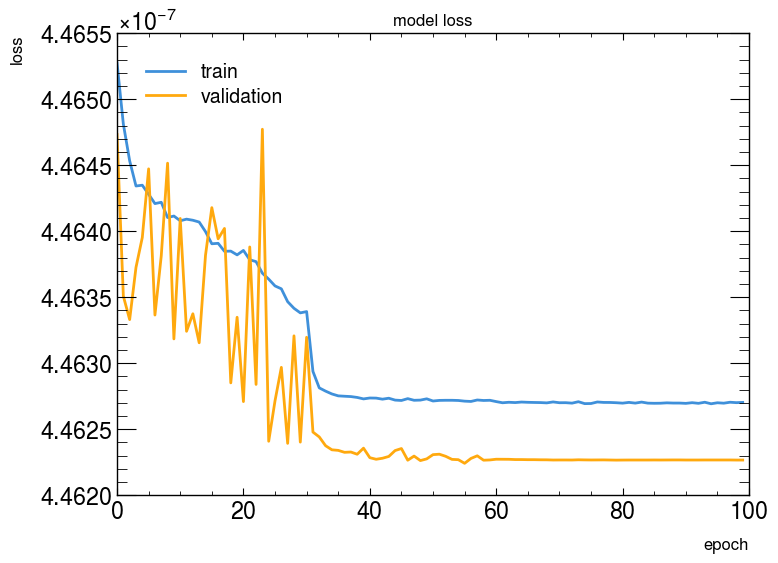

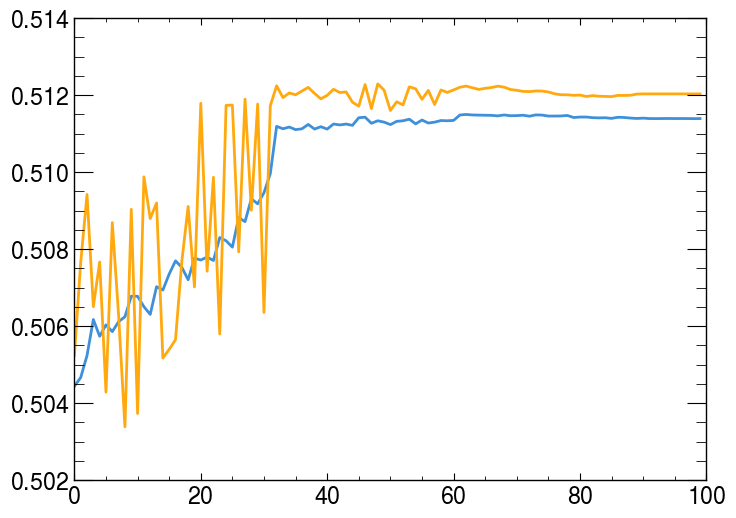

67924/67924 - 52s - 769us/step
0.4523647
0.5638128


In [ ]:
doCalibration=True

for process in labels_dict:
    
    for syst in dict_systs:

        print(f"\n\n Training for {syst}\n\n")

        if process not in dict_systs[syst]['process']:
            print(f"Nothing to train for {process} in {syst} uncertainty")
            continue
        
        for direction in dict_systs[syst]['directions']:

            # Train the density ratio NN
            NN_training_syst_process[process][syst][direction].train (   hidden_layers        = 2, 
                                                                         neurons              = 1000, 
                                                                         number_of_epochs     = 100, 
                                                                         batch_size           = 512, 
                                                                         learning_rate        = 0.1, 
                                                                         scalerType           = 'StandardScaler', 
                                                                         calibration          = doCalibration, 
                                                                         num_bins_cal         = 10, 
                                                                         callback             = True, 
                                                                         callback_patience    = 30, 
                                                                         callback_factor      = 0.01,
                                                                         verbose              = 2          )    
            
            NN_training_syst_process[process][syst][direction].test_normalization ( )    
            


In [ ]:
num_bins_cal = 50
NN_training_syst_process["htautau"]["TES"]["up"].make_calib_plots(nbins=num_bins_cal, observable='score')

In [ ]:
num_bins_cal = 50
NN_training_syst_process["htautau"]["TES"]["dn"].make_calib_plots(nbins=num_bins_cal, observable='score')


In [ ]:
variables_to_plot=['lepton_pt'] # The 1D variable for reweighting closure
yscale_type='log'
num_bins_plotting=21

NN_training_syst_process["htautau"]["TES"]["up"].make_reweighted_plots(variables_to_plot, yscale_type, num_bins_plotting)


In [ ]:
variables_to_plot=['lepton_pt'] # The 1D variable for reweighting closure
yscale_type='log'
num_bins_plotting=21

NN_training_syst_process["htautau"]["TES"]["dn"].make_reweighted_plots(variables_to_plot, yscale_type, num_bins_plotting)


In [ ]:
dataset_eval = pd.read_hdf(f"{saved_data}dataset_preselected_nominal_SR.h5", key="dataset", mode='r')

for process in labels_dict:
    
    for syst in dict_systs:

        if process not in dict_systs[syst]['process']:
            print(f"Nothing to evaluate for {process} in {syst} uncertainty")
            continue
        
        for direction in dict_systs[syst]['directions']:

            # Evaluate the density ratios p_alpha^\pm/p_nom for the nominal dataset
            NN_training_syst_process[process][syst][direction].evaluate_and_save_ratios(dataset_eval)


In [ ]:
# Save the systematic variation on total yields in the SR
nu_var_SR = {}
for process in labels_dict:

    mask_process_nom = dataset_nom_SR.type==process
    nu_var_SR[process] = {}
    
    for syst in dict_systs:

        nu_var_SR[process][syst] = {}
        
        for direction in dict_systs[syst]['directions']:
            
            if process not in dict_systs[syst]['process']:
                nu_var_SR[process][syst][direction] = 1.0
            else:
                
                mask_process_syst = (datasets_syst_SR[syst][direction].type==process)
                
                nu_var_SR[process][syst][direction] = datasets_syst_SR[syst][direction][mask_process_syst].weights.sum() / dataset_nom_SR[mask_process_nom].weights.sum()
                if 'down' not in dict_systs[syst]['directions']:
                    nu_var_SR[process][syst]['down'] = 2.0 - nu_var_SR[process][syst]['up']
                    
                

In [ ]:
# Save the Control Region variation histogram
with open(f"{saved_data}yield_SR_variations.pkl", "wb") as fp:
    pickle.dump(nu_var_SR, fp)